# Chapter 4 - Regression Extension Techniques for Time-­Series Data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

# ARIMA Model

In [3]:
url1 = ('https://raw.githubusercontent.com/Apress/hands-on-time-series-analylsis-python/refs/heads/master/Data/FB.csv')

df = pd.read_csv(url1)
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
1,2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2,2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
3,2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
4,2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
5,2014-12-15,78.459999,78.580002,76.559998,76.989998,76.989998,29396500
6,2014-12-16,76.190002,77.389999,74.589996,74.690002,74.690002,31554600
7,2014-12-17,75.010002,76.410004,74.900002,76.110001,76.110001,29203900
8,2014-12-18,76.889999,78.400002,76.510002,78.400002,78.400002,34222100
9,2014-12-19,78.750000,80.000000,78.330002,79.879997,79.879997,43335000


In [4]:
df['date'] = pd.to_datetime(df['Date'])    # Ensure it's in datetime format
df = df.set_index('date')                  # Set as index
df = df.sort_index()                       # Sort the index chronologically
df.drop(columns='Date', inplace=True)      # Drop 'Date' column if still present
df.head()

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2019-12-02,202.130005,202.179993,198.050003,199.699997,199.699997,11503400
2019-12-03,197.600006,198.929993,195.080002,198.820007,198.820007,11595300
2019-12-04,200.000000,200.029999,198.050003,198.710007,198.710007,8456300
2019-12-05,199.860001,201.289993,198.210007,199.360001,199.360001,9740400
2019-12-06,200.500000,201.566895,200.070007,201.050003,201.050003,12279525


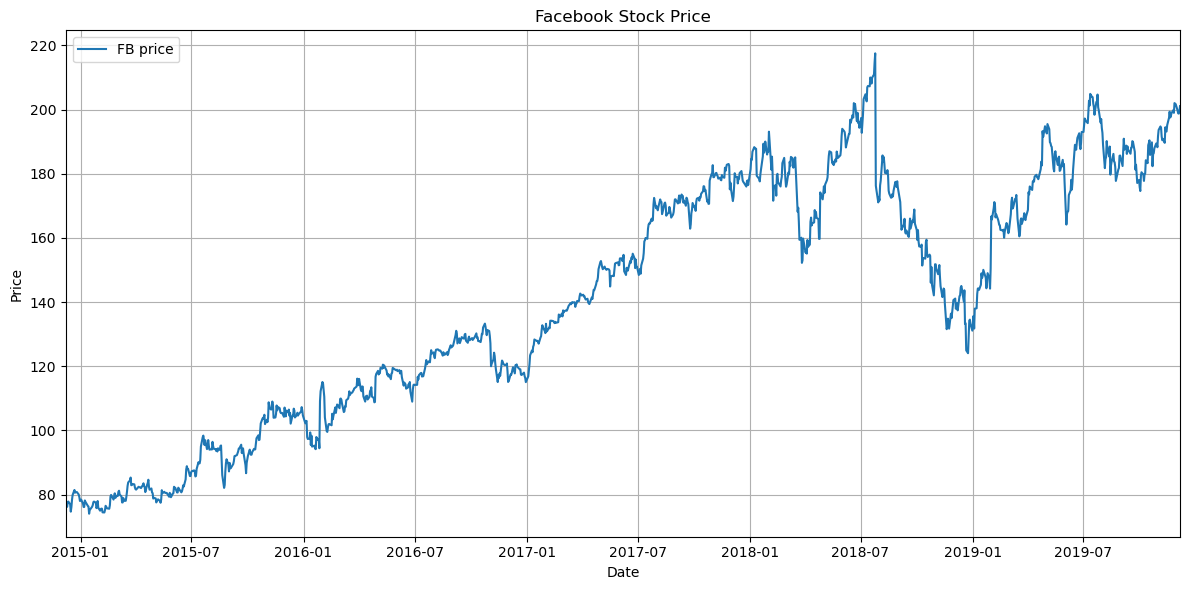

In [6]:
# Plot serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Close'], label='FB price')     

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2014-12-08'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

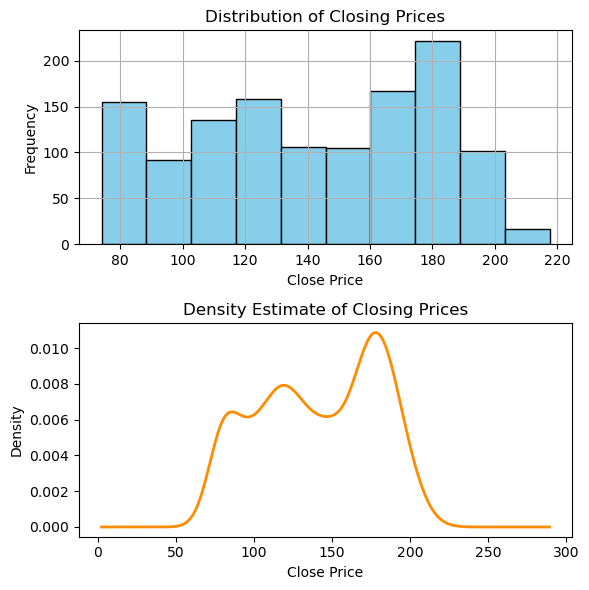

In [7]:
# Create a figure with two subplots: Histogram and KDE plot
plt.figure(figsize=(6, 6))                                 # Set overall figure size

# Histogram subplot
plt.subplot(2, 1, 1)                                       # First subplot (2 rows, 1 column, position 1)
df["Close"].hist(color='skyblue', edgecolor='black')       # Histogram with color
plt.title('Distribution of Closing Prices')                # Add title
plt.xlabel('Close Price')                                  # X-axis label
plt.ylabel('Frequency')                                    # Y-axis label

# KDE subplot
plt.subplot(2, 1, 2)                                        # Second subplot (2 rows, 1 column, position 2)
df["Close"].plot(kind='kde', color='darkorange', linewidth=2)  # KDE plot with color and thicker line
plt.title('Density Estimate of Closing Prices')            # Add title
plt.xlabel('Close Price')                                  # X-axis label

# Improve layout
plt.tight_layout()                                         # Prevent overlapping of subplots
plt.show()                                                 # Display the plots

In [8]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    print('Evaluation metric results:')
    print(f' MSE is : {metrics.mean_squared_error(y_true, y_pred):.4f}')
    print(f' MSE is : {metrics.mean_absolute_error(y_true, y_pred):.4f}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred)):.4f}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred):.4f}')
    print(f'  R2 is : {metrics.r2_score(y_true, y_pred):.4f}',end='\n\n')

In [9]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [10]:
Augmented_Dickey_Fuller_Test_func(df['Close' ],'Close')

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.338096
p-value                           0.611568
No Lags Used                      0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [11]:
X = df[['Close' ]]

train, test = X[0:-30], X[-30:]

In [12]:
# ARIMA Model
stepwise_model = auto_arima(train,                  # Time series data
                            start_p=1,              # Initial value of p (AR term)
                            start_q=1,              # Initial value of q (MA term)
                            max_p=7,                # Maximum value for p to test
                            max_q=7,                # Maximum value for q to test
                            seasonal=False,         # No seasonal component (set to True for SARIMA)
                            d=None,                 # Let the model determine order of differencing
                            trace=True,             # Print the progress of model selection
                            error_action='ignore',  # Ignore model fitting errors
                            suppress_warnings=True, # Suppress convergence and stationarity warnings
                            stepwise=True)          # Use stepwise algorithm for faster model selection

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5926.792, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5929.302, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5930.825, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5930.810, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5928.648, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5928.521, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5930.139, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5932.491, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5932.541, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5927.184, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.345 seconds


In [13]:
# Display summary of the model
print(stepwise_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1229
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2959.396
Date:                Fri, 11 Apr 2025   AIC                           5926.792
Time:                        10:13:43   BIC                           5947.245
Sample:                             0   HQIC                          5934.488
                               - 1229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.012      1.046      0.296      -0.011       0.035
ar.L1          0.8631      0.087      9.909      0.000       0.692       1.034
ma.L1         -0.8999      0.076    -11.854      0.0

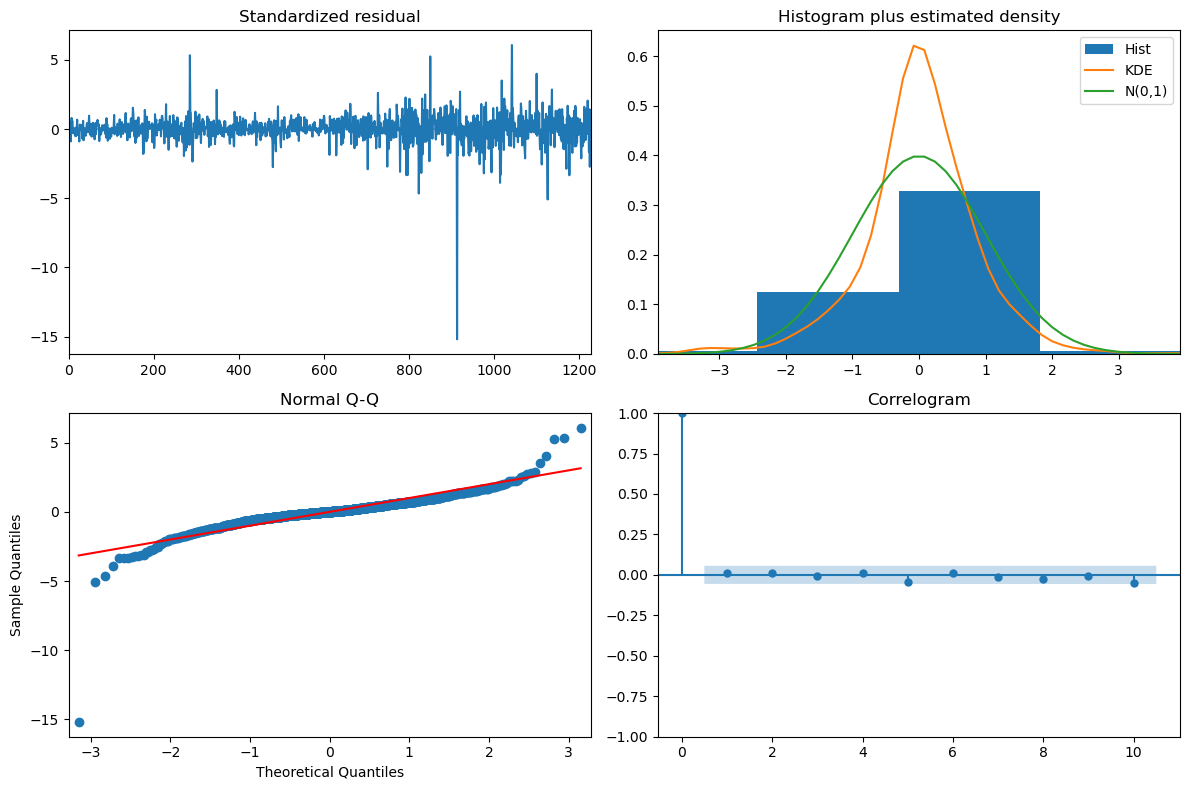

In [14]:
stepwise_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [15]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])

conf_int[:5]

array([[181.15366217, 191.71340317],
       [179.1610993 , 193.82277821],
       [177.72682877, 195.38228187],
       [176.58514904, 196.65646268],
       [175.63018589, 197.75019978]])

In [16]:
# Model for ARIMA not SARIMA

forecast, conf_int = stepwise_model.predict(n_periods=30, return_conf_int=True)  # Generate forecast and confidence intervals
forecast_df = pd.DataFrame(forecast, columns=['close_pred'])                     # Wrap forecast into DataFrame

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_df.values                                            # Add forecasted values to test set
test['Error'] = test['Forecast'] - test['Close']                                 # Calculate forecast error

# Assign confidence intervals directly (no .values needed for NumPy array slicing)
test['Lower 95% CI'] = conf_int[:, 0]                                            # Lower bound of CI
test['Upper 95% CI'] = conf_int[:, 1]                                            # Upper bound of CI

# Show the updated test DataFrame
test.head()

,Close,Forecast,Error,Lower 95% CI,Upper 95% CI
date,,,,,
2019-10-25,187.889999,186.433533,-1.456466,181.153662,191.713403
2019-10-28,189.399994,186.491939,-2.908055,179.161099,193.822778
2019-10-29,189.309998,186.554555,-2.755443,177.726829,195.382282
2019-10-30,188.250000,186.620806,-1.629194,176.585149,196.656463
2019-10-31,191.649994,186.690193,-4.959801,175.630186,197.750200


In [17]:
# Evaluate forecast performance by comparing predicted values against the actual test set
timeseries_evaluation_metrics_func(test['Close'], test['Forecast'])

Evaluation metric results:
 MSE is : 73.0120
 MSE is : 7.7279
RMSE is : 8.5447
MAPE is : 3.9182
  R2 is : -2.9891



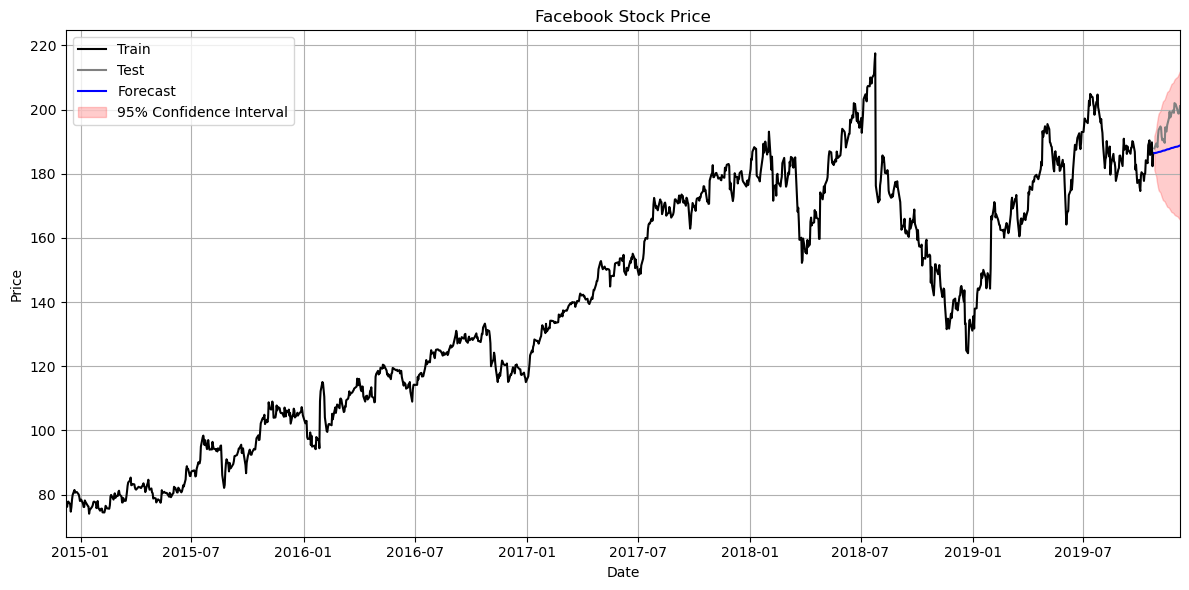

In [18]:
# Plot serie
plt.figure(figsize=(12, 6))                                      

plt.plot(train.index, train ['Close'], label='Train', color='black')                      
plt.plot(test.index, test['Close'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast'], label='Forecast', color='blue') 

# Add 95% confidence bands
plt.fill_between(test.index,
                 test['Lower 95% CI'],   # Lower bound
                 test['Upper 95% CI'],   # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2014-12-08'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

# SARIMA Model

In [19]:
X = df[['Close' ]]

train, test2 = X[0:-30], X[-30:]

In [20]:
from statsmodels.tsa.stattools import adfuller

def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(train['Close'])
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.5242, p-value = 0.5215
d = 1 | ADF Statistic = -35.6967, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [21]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
        
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(train['Close'], m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


In [22]:
stepwise_models = auto_arima(train, 
                            start_p=1, max_p=7,
                            start_q=1, max_q=7,
                            d=1, D=0, 
                            seasonal=True, 
                            start_P=1, max_P=7,
                            start_Q=1, max_Q=7,  
                            m=30,
                            trace=False, 
                            error_action='ignore', 
                            suppress_warnings=True, 
                            stepwise=True)

# Print the best model found
print(f"Best model: SARIMA{stepwise_models.order}{stepwise_models.seasonal_order}")

Best model: SARIMA(1, 1, 1)(1, 0, 0, 30)


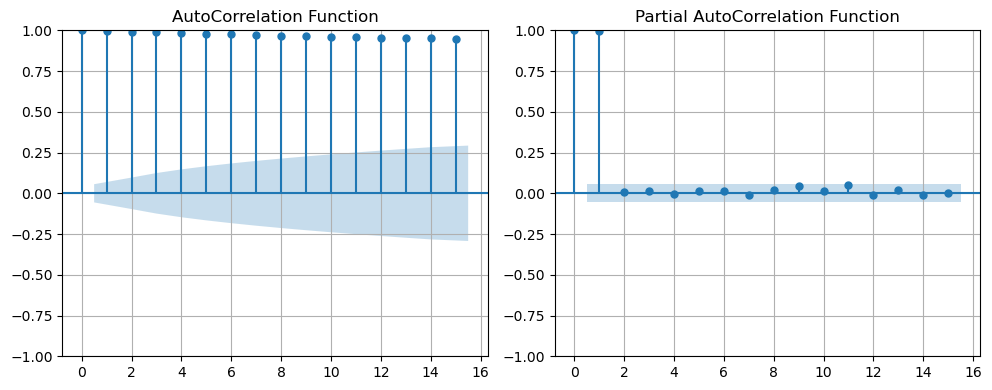

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(train['Close'], ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(train['Close'], ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show();

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA (p,d,q)(P,D,Q,S) model
stepwise_models = SARIMAX(train['Close'],                 # Time series data
                    order=(1, 1, 1),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 0, 30),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
stepwise_model_fits = stepwise_models.fit()

# Display summary of the model
print(stepwise_model_fits.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1229
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 30)   Log Likelihood               -2897.156
Date:                             Fri, 11 Apr 2025   AIC                           5802.312
Time:                                     10:17:24   BIC                           5822.662
Sample:                                          0   HQIC                          5809.979
                                            - 1229                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8418      0.120      7.033      0.000       0.607       1.076
ma.L1         -0.8766      

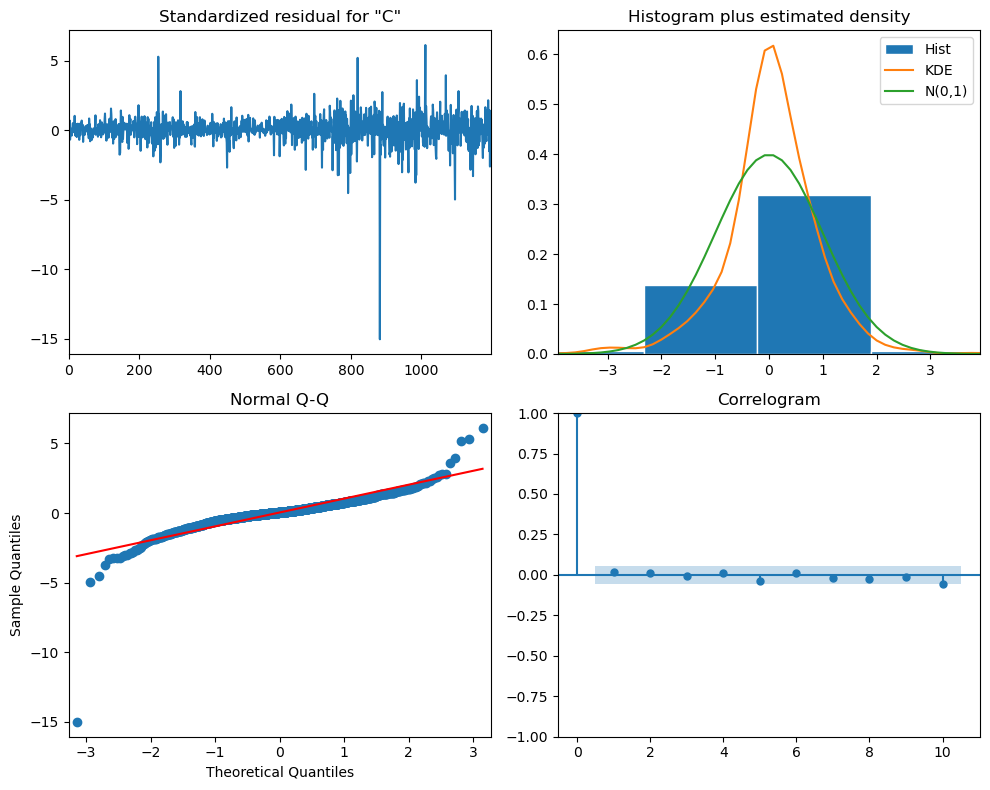

In [25]:
# Extract the residuals (errors) from the fitted model
residualss = stepwise_model_fits.resid  

# Diagnostic plots for the model, including residuals and other model checks
stepwise_model_fits.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residualss = acorr_ljungbox(residualss, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residualss['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residualss

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,26.081569,3.272933e-07
2,26.105995,2.143656e-06
3,26.203947,8.644171e-06
4,26.213048,2.866348e-05
5,27.001342,5.700815e-05
6,27.124104,1.372569e-04
7,27.155403,3.124816e-04
8,27.255837,6.385381e-04
9,27.390560,1.205071e-03
10,28.139669,1.714581e-03


In [27]:
# Forecast the next 12 time points
forecast_30s = stepwise_model_fits.get_forecast(steps=30)

# Extract predicted mean and confidence intervals
forecast_mean_30s = forecast_30s.predicted_mean
conf_int_30s = forecast_30s.conf_int()

# Assign forecasts to the test DataFrame
test2['ForecastS'] = forecast_mean_30s.values                                # Forecast mean

test2['ErrorS'] = test2['ForecastS'] - test2['Close']

test2['Lower 95% CIS'] = conf_int_30s.iloc[:, 0].values                      # Lower bound
test2['Upper 95% CIS'] = conf_int_30s.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test2.head()

,Close,ForecastS,ErrorS,Lower 95% CIS,Upper 95% CIS
date,,,,,
2019-10-25,187.889999,186.310560,-1.579439,180.978555,191.642566
2019-10-28,189.399994,186.209212,-3.190782,178.798840,193.619584
2019-10-29,189.309998,186.280233,-3.029765,177.346504,195.213963
2019-10-30,188.250000,186.252069,-1.997931,176.082861,196.421277
2019-10-31,191.649994,186.342230,-5.307764,175.119512,197.564948


In [28]:
# Evaluate forecast performance by comparing predicted values against the actual test set
timeseries_evaluation_metrics_func(test2['Close'], test2['ForecastS'])

Evaluation metric results:
 MSE is : 106.9496
 MSE is : 9.4018
RMSE is : 10.3416
MAPE is : 4.7683
  R2 is : -4.8434



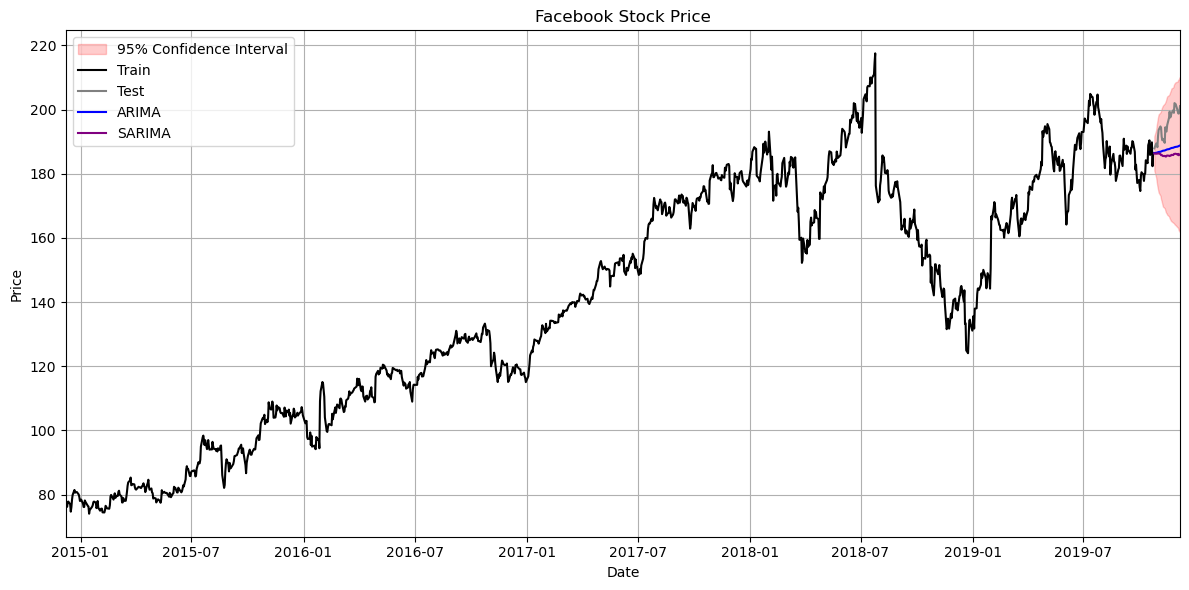

In [29]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_30s.iloc[:, 0],     # Lower bound
                 conf_int_30s.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train ['Close'], label='Train', color='black')                      
plt.plot(test.index, test['Close'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast'], label='ARIMA', color='blue') 
plt.plot(test.index, test2['ForecastS'], label='SARIMA', color='purple') 

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2014-12-08'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

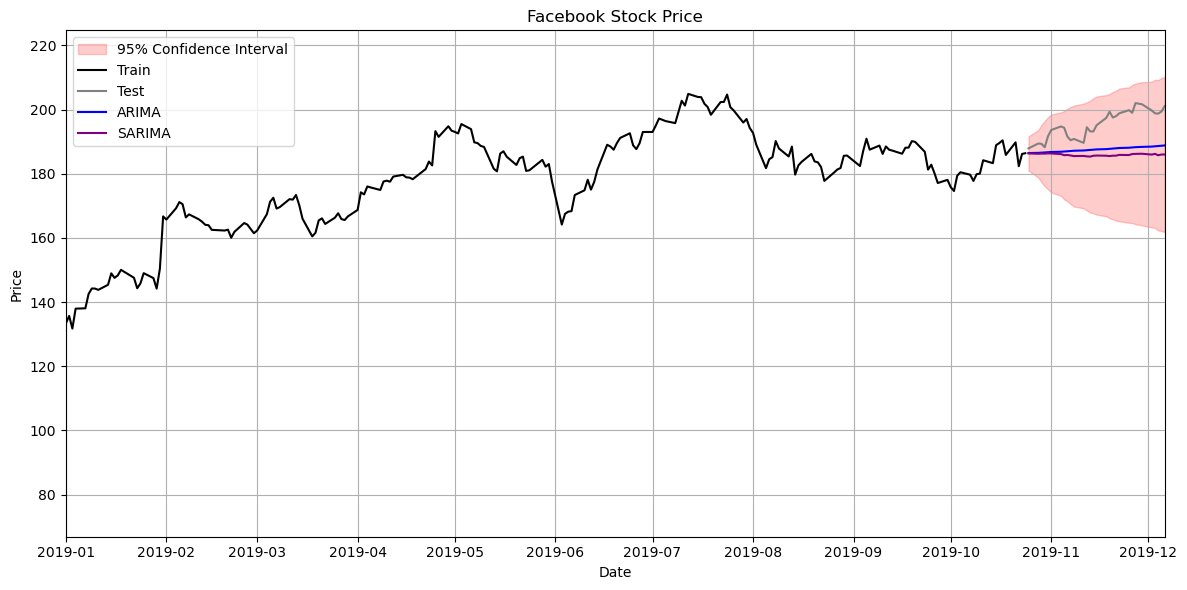

In [30]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_30s.iloc[:, 0],     # Lower bound
                 conf_int_30s.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train ['Close'], label='Train', color='black')                      
plt.plot(test.index, test['Close'], label='Test', color='gray')     
plt.plot(test.index, test['Forecast'], label='ARIMA', color='blue') 
plt.plot(test.index, test2['ForecastS'], label='SARIMA', color='purple') 

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [31]:
# Calculate MAPE for each forecast
mape_arima = (np.abs(test['Error']) / test['Close']).mean() * 100
mape_sarima = (np.abs(test2['ErrorS']) / test2['Close']).mean() * 100

# Display MAPE results
print(f' MAPE for ARIMA model: {mape_arima:.2f}')
print(f'MAPE for SARIMA model: {mape_sarima:.2f}')

 MAPE for ARIMA model: 3.92
MAPE for SARIMA model: 4.77


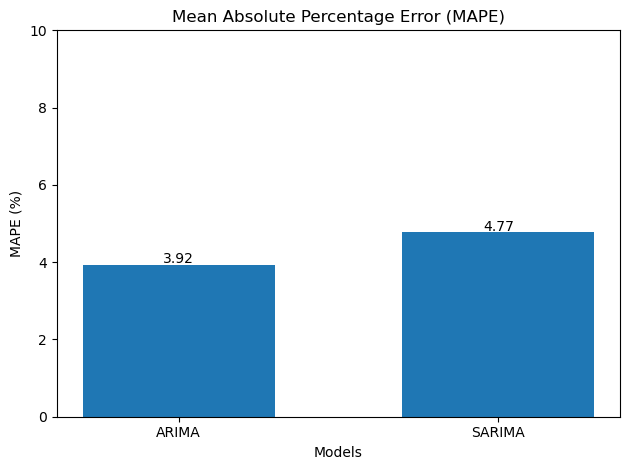

In [32]:
fig, ax = plt.subplots()

x = ['ARIMA', 'SARIMA']
y = [mape_arima, mape_sarima]

ax.bar(x, y, width=0.6)
ax.set_title('Mean Absolute Percentage Error (MAPE)')
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 10)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()

ARIMA is preferred over SARIMA for this dataset based on the MAPE comparison (3.92% vs 4.77%).